In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets.cifar10 import load_data
((x_train, y_train), (x_test, y_test)) = load_data()

Using TensorFlow backend.


In [2]:
print("訓練資料有幾筆呢?", x_train.shape)
print("測試資料有幾筆呢?", x_test.shape)

訓練資料有幾筆呢? (50000, 32, 32, 3)
測試資料有幾筆呢? (10000, 32, 32, 3)


In [3]:
trans = {0:"飛機", 1:"汽車", 2:"鳥", 3:"貓", 4:"鹿",
         5:"狗", 6:"青蛙", 7:"馬", 8:"船", 9:"卡車"}

這幅圖片是: 鳥


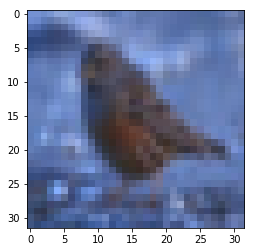

In [4]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
c = random.randint(0, 49999)
print("這幅圖片是:", trans[y_train[c][0]])
plt.imshow(x_train[c])

In [5]:
# 資料預處理
# 圖片: 標準化(0 - 1)
x_train_reshape = x_train / 255
x_test_reshape = x_test / 255
# 答案: 把你的答案變成每一個輸出神經元都要一個值(One-Hot)
from keras.utils import np_utils
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)

In [6]:
print("秀一筆", y_train[0] , "給你看", y_train_cat[0])

秀一筆 [6] 給你看 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
cnn = Sequential()
# 只要第一層, 一定要固定輸入大小
# 卷積: 抓特徵
# Param: 3 * 3(一個filter格子數) * 3(格子裡參數RGB) * 32(個filter) + 32(bias) = 896
cnn.add(Conv2D(input_shape=(32, 32, 3),
               kernel_size=(3, 3),
               filters=32,
               activation="relu",
               padding="same"))
# 池化: 減低計算量
cnn.add(MaxPooling2D(pool_size=(2, 2)))
# Param: 3 * 3(一個filter格子數) * 32(格子裡參數) * 64(個filter) + 64(bias) = 18496
cnn.add(Conv2D(kernel_size=(3, 3),
               filters=64,
               activation="relu",
               padding="same"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(kernel_size=(3, 3),
               filters=128,
               activation="relu",
               padding="same"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
# 加上大腦
cnn.add(Flatten())
cnn.add(Dense(units=512, activation="relu"))
cnn.add(Dense(units=128, activation="relu"))
cnn.add(Dense(units=10, activation="softmax"))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
__________

In [16]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
# 更新次數: 50000 * 10 / 200
train_history = cnn.fit(x=x_train_reshape, y=y_train_cat, 
                        batch_size=200, epochs=10, 
                        validation_split=0.1, verbose=2)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
 - 76s - loss: 1.3415 - acc: 0.5146 - val_loss: 1.1404 - val_acc: 0.5896
Epoch 2/10
 - 78s - loss: 1.0675 - acc: 0.6212 - val_loss: 0.9928 - val_acc: 0.6552
Epoch 3/10
 - 79s - loss: 0.9107 - acc: 0.6801 - val_loss: 0.8759 - val_acc: 0.7010
Epoch 4/10
 - 75s - loss: 0.7930 - acc: 0.7231 - val_loss: 0.8347 - val_acc: 0.7098
Epoch 5/10
 - 75s - loss: 0.7169 - acc: 0.7488 - val_loss: 0.7922 - val_acc: 0.7304
Epoch 6/10
 - 75s - loss: 0.6209 - acc: 0.7855 - val_loss: 0.8033 - val_acc: 0.7258
Epoch 7/10
 - 75s - loss: 0.5460 - acc: 0.8096 - val_loss: 0.7679 - val_acc: 0.7392
Epoch 8/10
 - 74s - loss: 0.4664 - acc: 0.8378 - val_loss: 0.7782 - val_acc: 0.7492
Epoch 9/10
 - 86s - loss: 0.3982 - acc: 0.8621 - val_loss: 0.7724 - val_acc: 0.7564
Epoch 10/10
 - 82s - loss: 0.3222 - acc: 0.8876 - val_loss: 0.7788 - val_acc: 0.7656


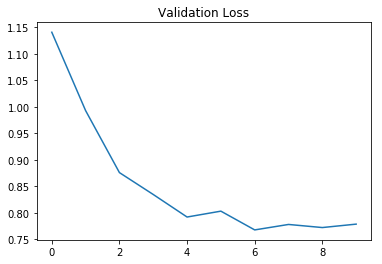

In [20]:
y = train_history.history["val_loss"]
plt.title("Validation Loss")
plt.plot(y)

In [21]:
print("預測:", cnn.predict_classes(x_test_reshape))
print("[Loss, Accuracy]", cnn.evaluate(x_test_reshape, y_test_cat))

預測: [5 8 8 ... 5 4 7]
10000/10000 [==============================] - 7s 666us/step
[Loss, Accuracy] [0.822441515159607, 0.7487]


In [23]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, cnn.predict_classes(x_test_reshape)))

,0,1,2,3,4,5,6,7,8,9
0,822,17,35,16,16,9,7,11,42,25
1,11,913,7,5,2,1,2,2,21,36
2,61,9,658,55,61,48,57,29,11,11
3,15,17,70,572,59,154,55,31,9,18
4,22,4,99,57,692,39,39,37,8,3
5,16,7,46,174,36,643,23,41,4,10
6,5,8,45,55,25,21,827,5,3,6
7,13,6,34,43,80,34,5,766,3,16
8,67,37,16,11,6,5,6,2,830,20
9,37,134,13,14,5,7,1,8,17,764


In [24]:
# 儲存model
cnn.save("firstcnn.h5")

In [25]:
# 讀取model
from keras.models import load_model
loadcnn = load_model("firstcnn.h5")
loadcnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
loadcnn.evaluate(x_test_reshape, y_test_cat)

10000/10000 [==============================] - 8s 822us/step


[0.822441515159607, 0.7487]